# Imports

In [20]:
from seaexplorertools import process_adcp
import xarray as xr
import numpy as np
import pandas as pd

# Begin ADCP Data Processing

Set paths to input files and specify options

In [21]:
adcp_path = 'ADCP_refactoring_test_files/sea045_M44.ad2cp.00000*.nc'
glider_pqt_path = 'ADCP_refactoring_test_files/Skag_test.pqt'

options = {
    'debug_plots' : True,
    'correctADCPHeading' : True,
    'ADCP_discardFirstBins' : 0, # First bin often very affected by glider, good to discard, in future we should extend blanking distance
    'ADCP_correlationThreshold': 70, # 70
    'ADCP_amplitudeThreshold' : 75, # 75
    'ADCP_velocityThreshold' : 0.8, # 0.6
    'correctXshear' : False,
    'correctYshear' : False,
    'correctZshear' : False,
    'correctZZshear' : False,
    'ADCP_regrid_correlation_threshold': 20,
    'plots_directory': 'plots',
    }


## Load ADCP data and add necessary glider variables

In [22]:
ADCP, data, options = process_adcp.load_adcp_glider_data(adcp_path, glider_pqt_path, options)

Loaded ADCP_refactoring_test_files/Skag_test.pqt
2023-07-24 11:37:16 : Finished loading ADCP data
2023-07-24 11:37:16 : Added glider variables
2023-07-24 11:37:16 : top mounted: True


In [23]:
data = data[data.profile_number < 199]
ADCP = ADCP.where(ADCP.time < data.time.values[-1]).dropna(dim="time", how="all")


# Start QC Calculate depth of each individual measurement


2023-07-24 11:37:18 : Depth calculation of cells correct. Beam 1 2 4 match on down; 3 2 4 match on up. (Tested on downward facing)


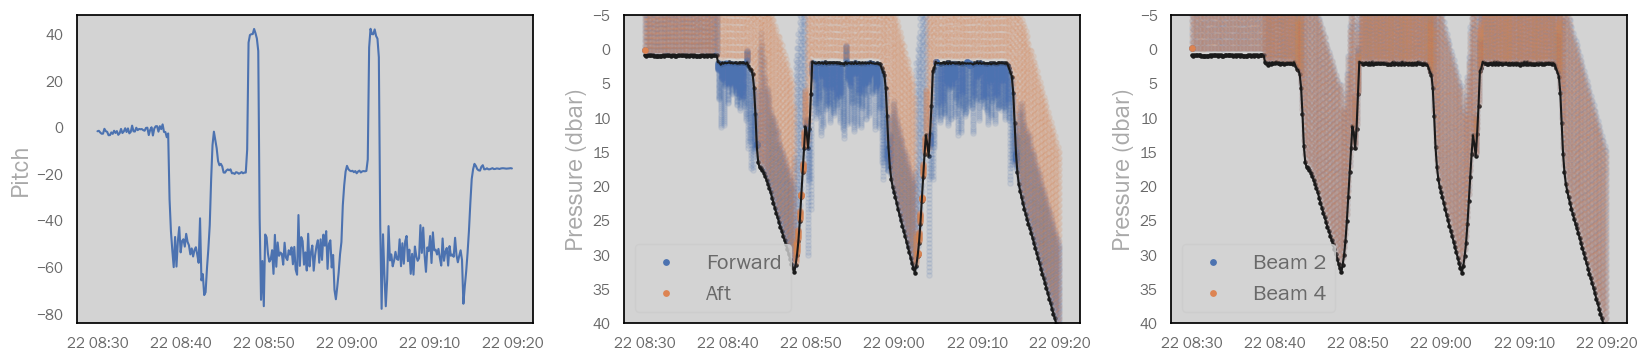

In [24]:
ADCP = process_adcp.remapADCPdepth(ADCP, options)

In [25]:
## ADJUST DISTANCE BASED ON SOUNDSPEED !

## Correct ADCP Heading

        <total-intensity units="nT">51043</total-intensity>

Target = 510.43
Optimization terminated successfully.
         Current function value: 1.707746
         Iterations: 1392
         Function evaluations: 1935
[[ 0.8218908  -0.00215635 -0.0088071 ]
 [-0.00226646  0.86730429 -0.02489248]
 [-0.02411338  0.00473393  0.85283387]]
[ 0.07404023 -0.05074324  0.03226842]
2023-07-24 11:37:39 : Corrected heading and accounted for declination


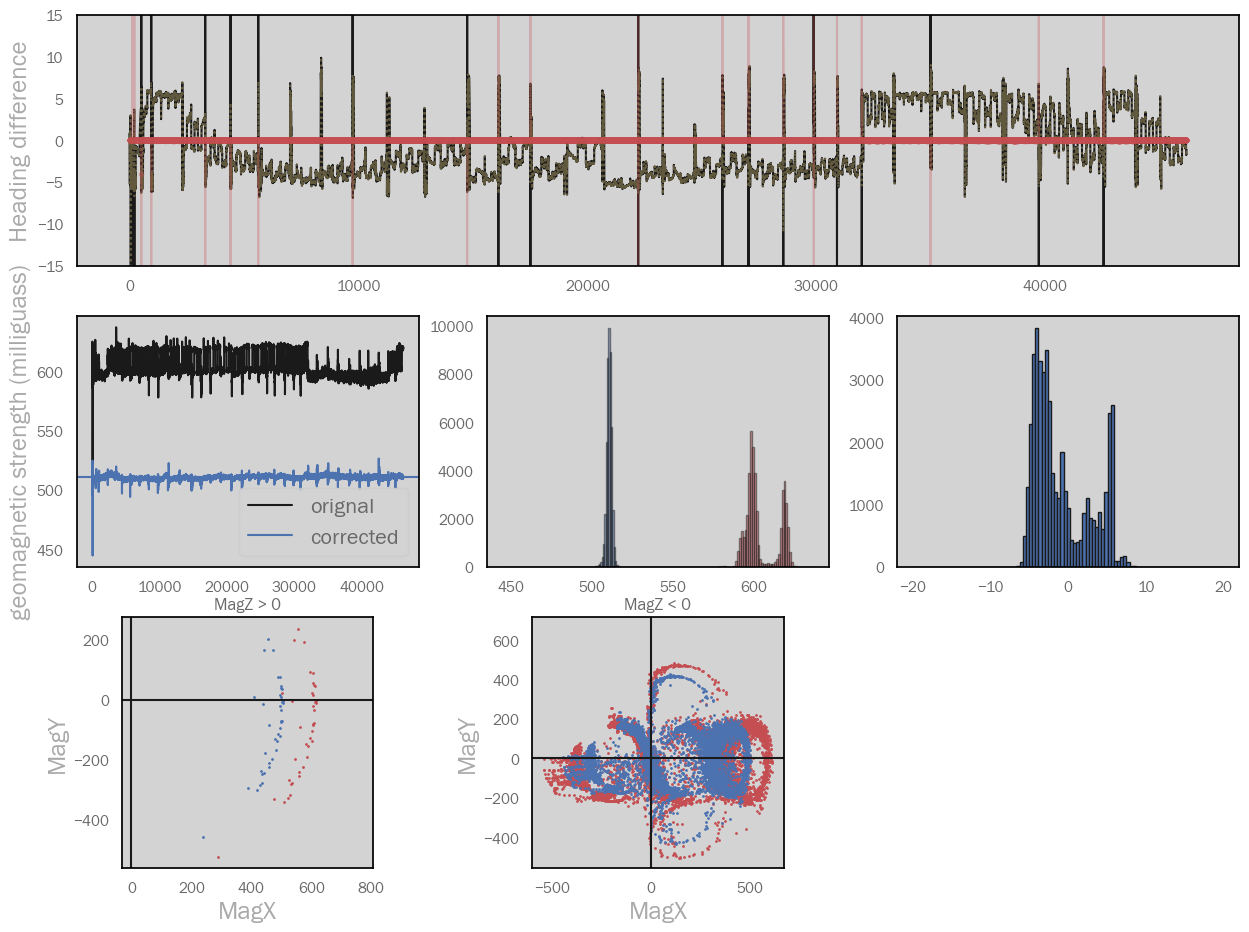

In [26]:
ADCP = process_adcp.correct_heading(ADCP, data, options)

## Perform soundspeed correction

In [27]:
ADCP = process_adcp.soundspeed_correction(ADCP)

2023-07-24 11:37:40 : Corrected beam 1 velocity for sound speed.
2023-07-24 11:37:40 : Corrected beam 2 velocity for sound speed.
2023-07-24 11:37:40 : Corrected beam 3 velocity for sound speed.
2023-07-24 11:37:40 : Corrected beam 4 velocity for sound speed.


## Outlier and poor correlation removal


Now we need to think. What do we discard, what do we keep, do we interpolate across missing bins?

2023-07-24 11:37:45 : Beam 1 correlation: 42.4% removed
2023-07-24 11:37:45 : Beam 1 amplitude: 0.4% removed
2023-07-24 11:37:45 : Beam 1 velocity: 1.4% removed
2023-07-24 11:37:45 : Beam 2 correlation: 42.6% removed
2023-07-24 11:37:45 : Beam 2 amplitude: 0.6% removed
2023-07-24 11:37:45 : Beam 2 velocity: 1.3% removed
2023-07-24 11:37:46 : Beam 3 correlation: 43.6% removed
2023-07-24 11:37:46 : Beam 3 amplitude: 0.6% removed
2023-07-24 11:37:46 : Beam 3 velocity: 1.7% removed
2023-07-24 11:37:46 : Beam 4 correlation: 41.5% removed
2023-07-24 11:37:46 : Beam 4 amplitude: 0.6% removed
2023-07-24 11:37:46 : Beam 4 velocity: 1.2% removed


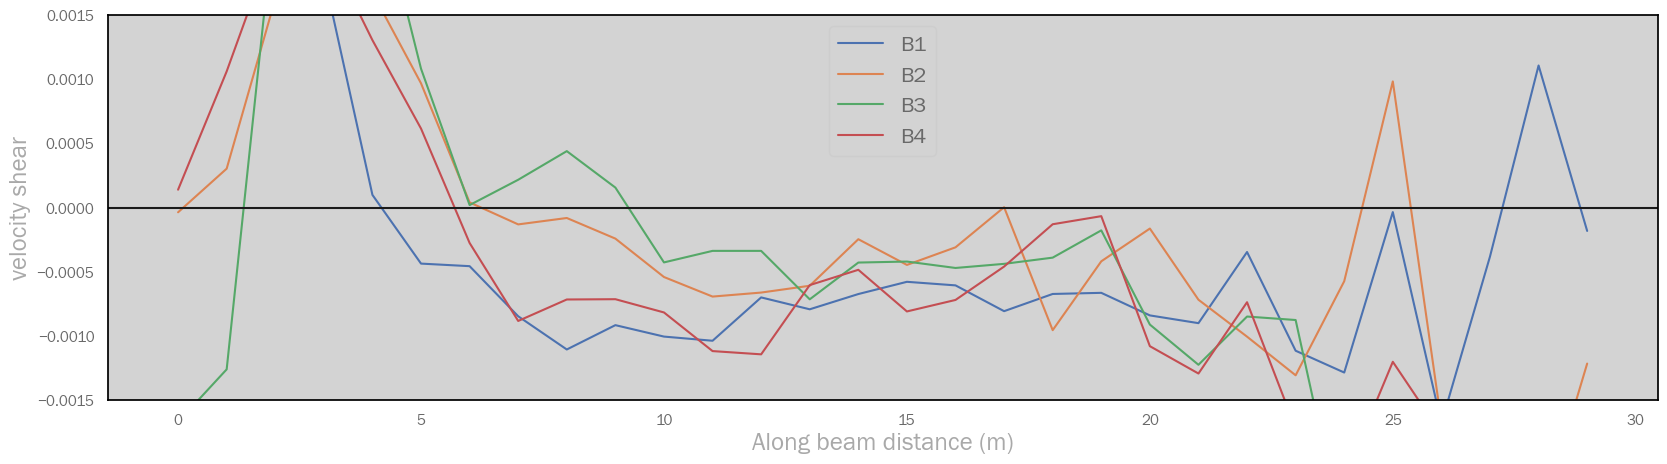

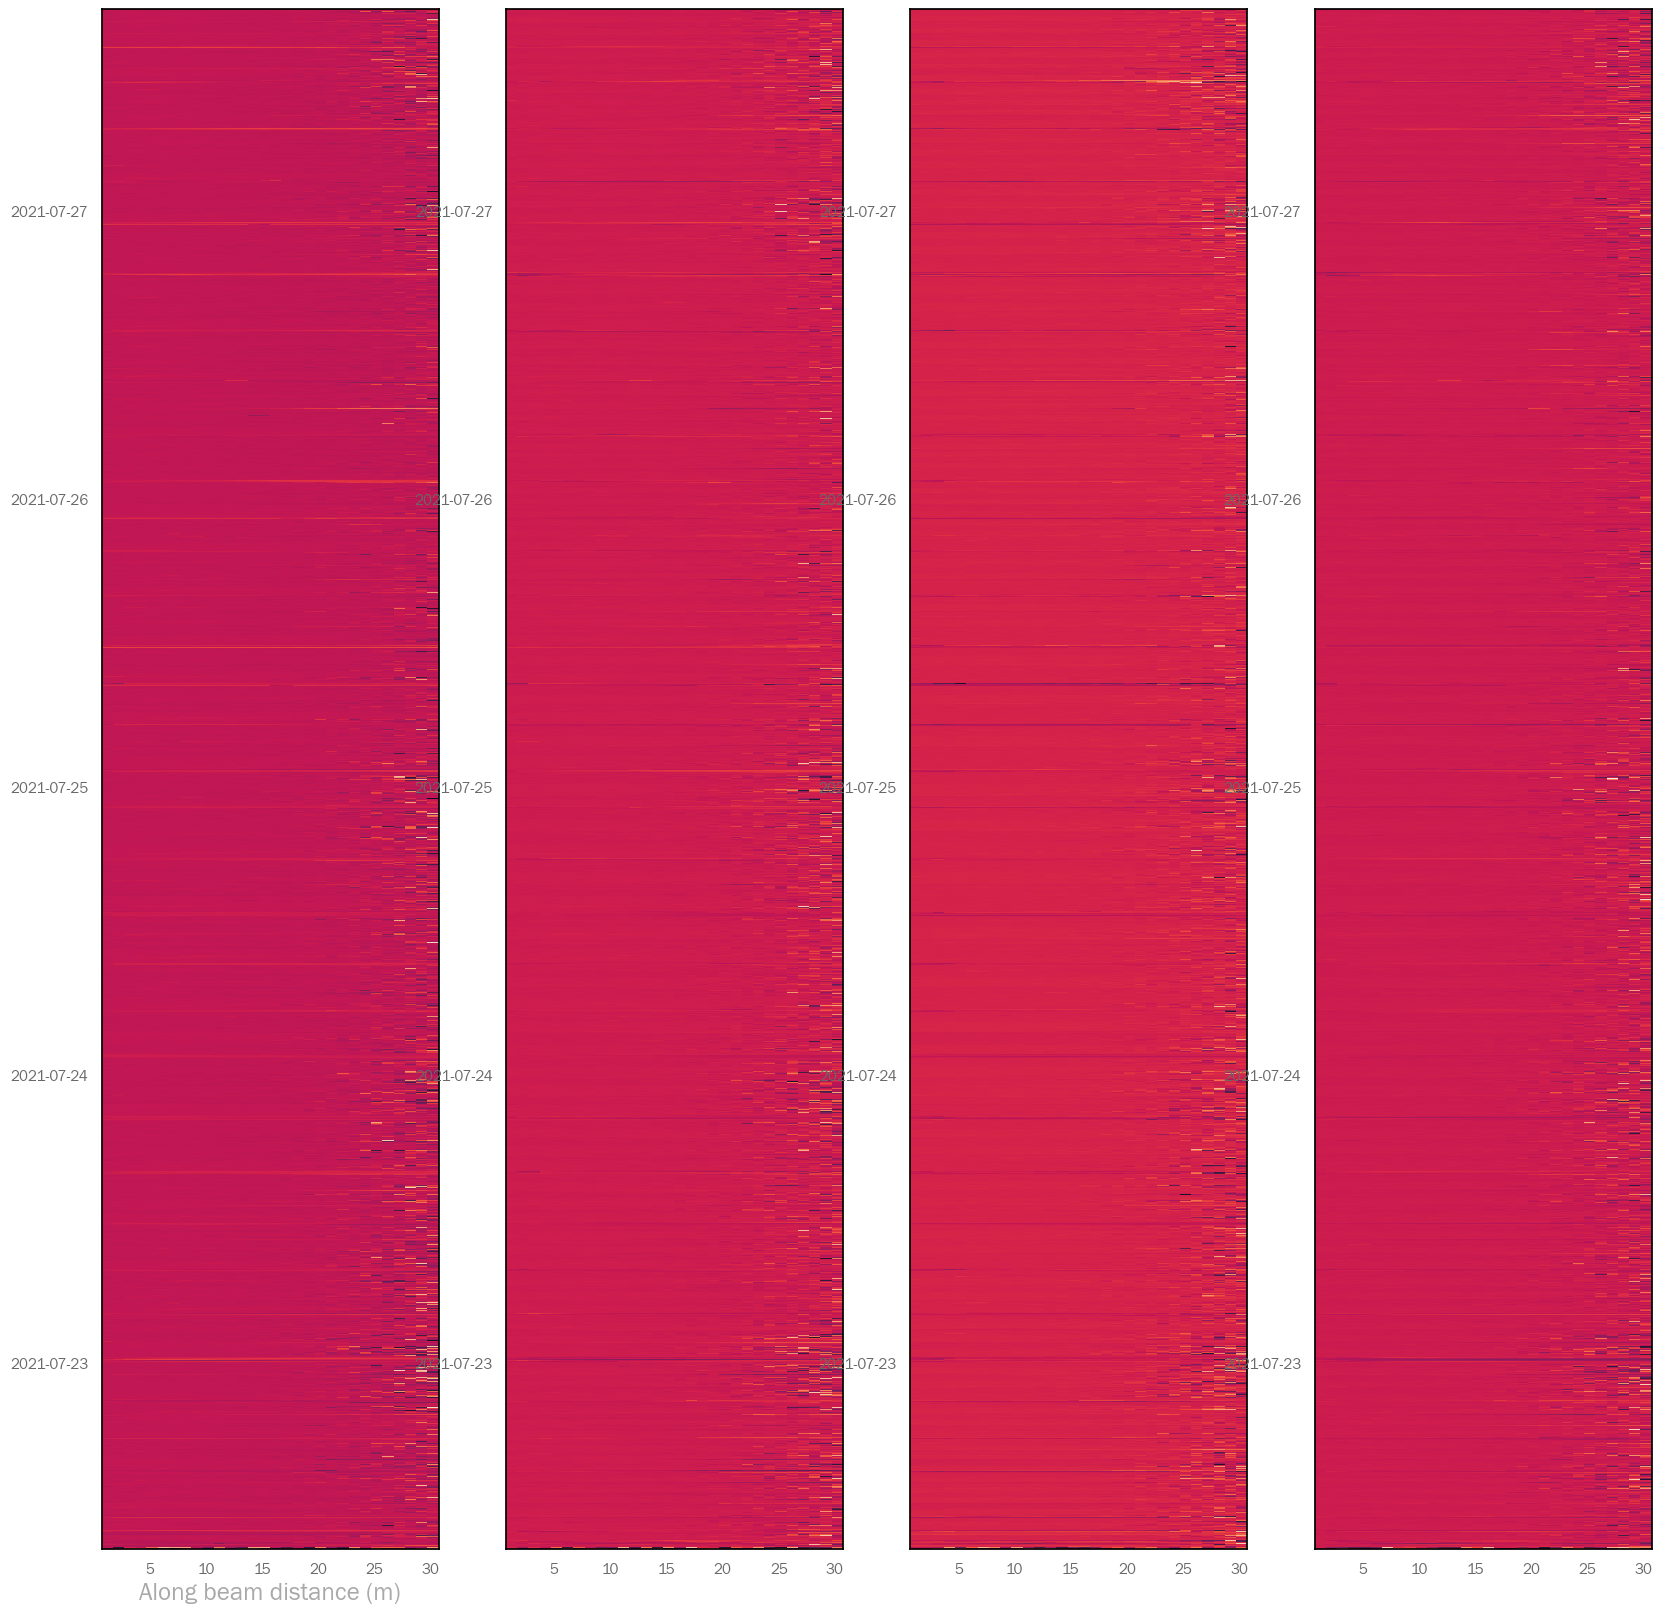

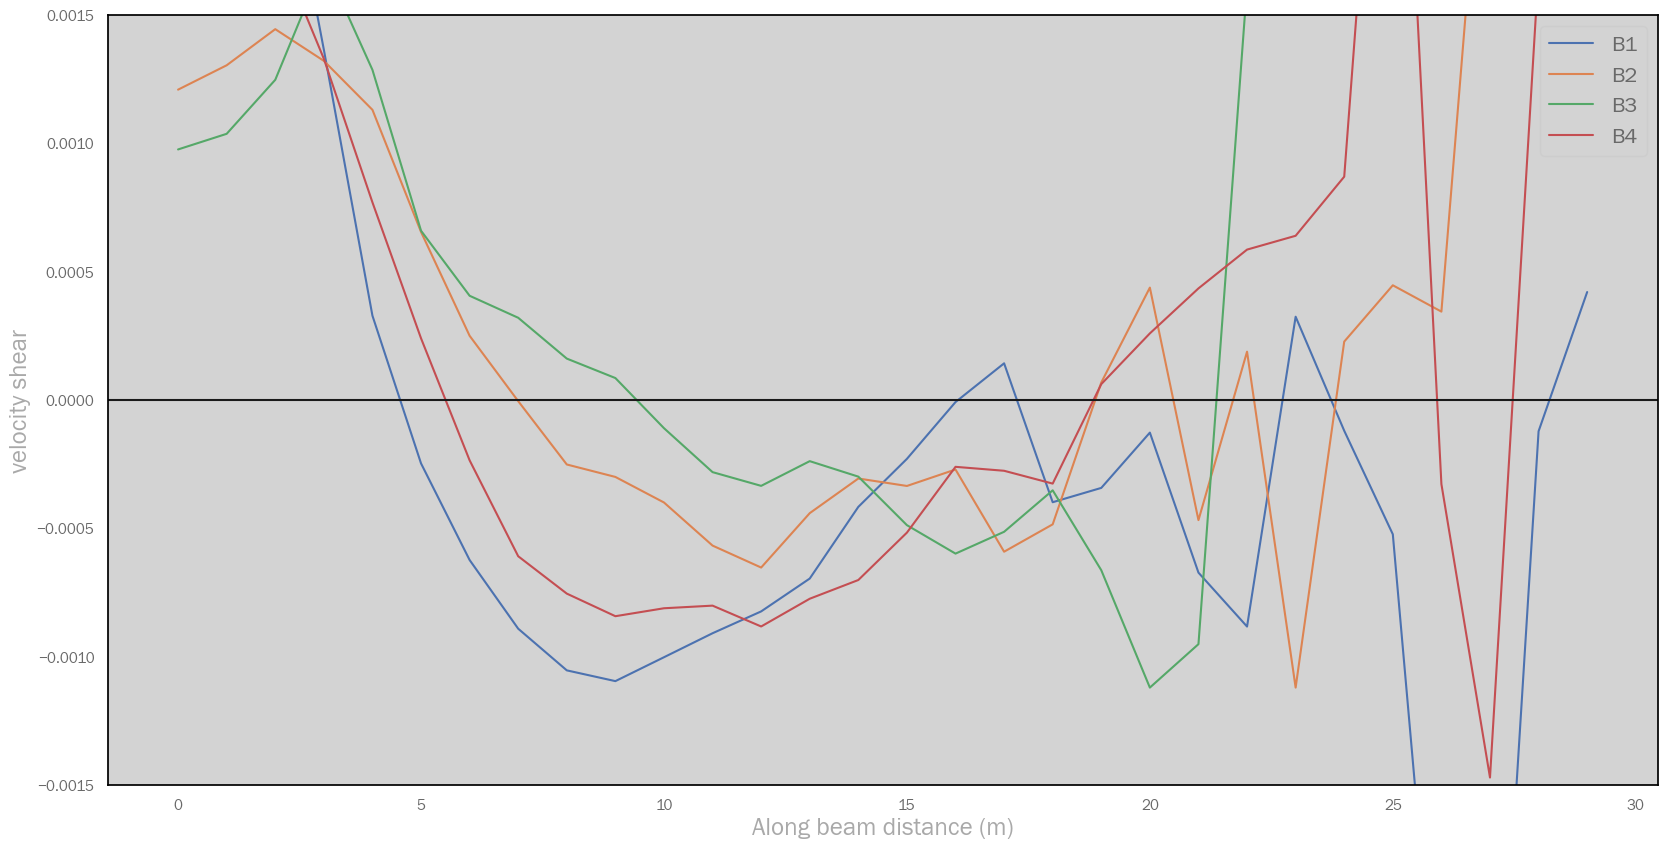

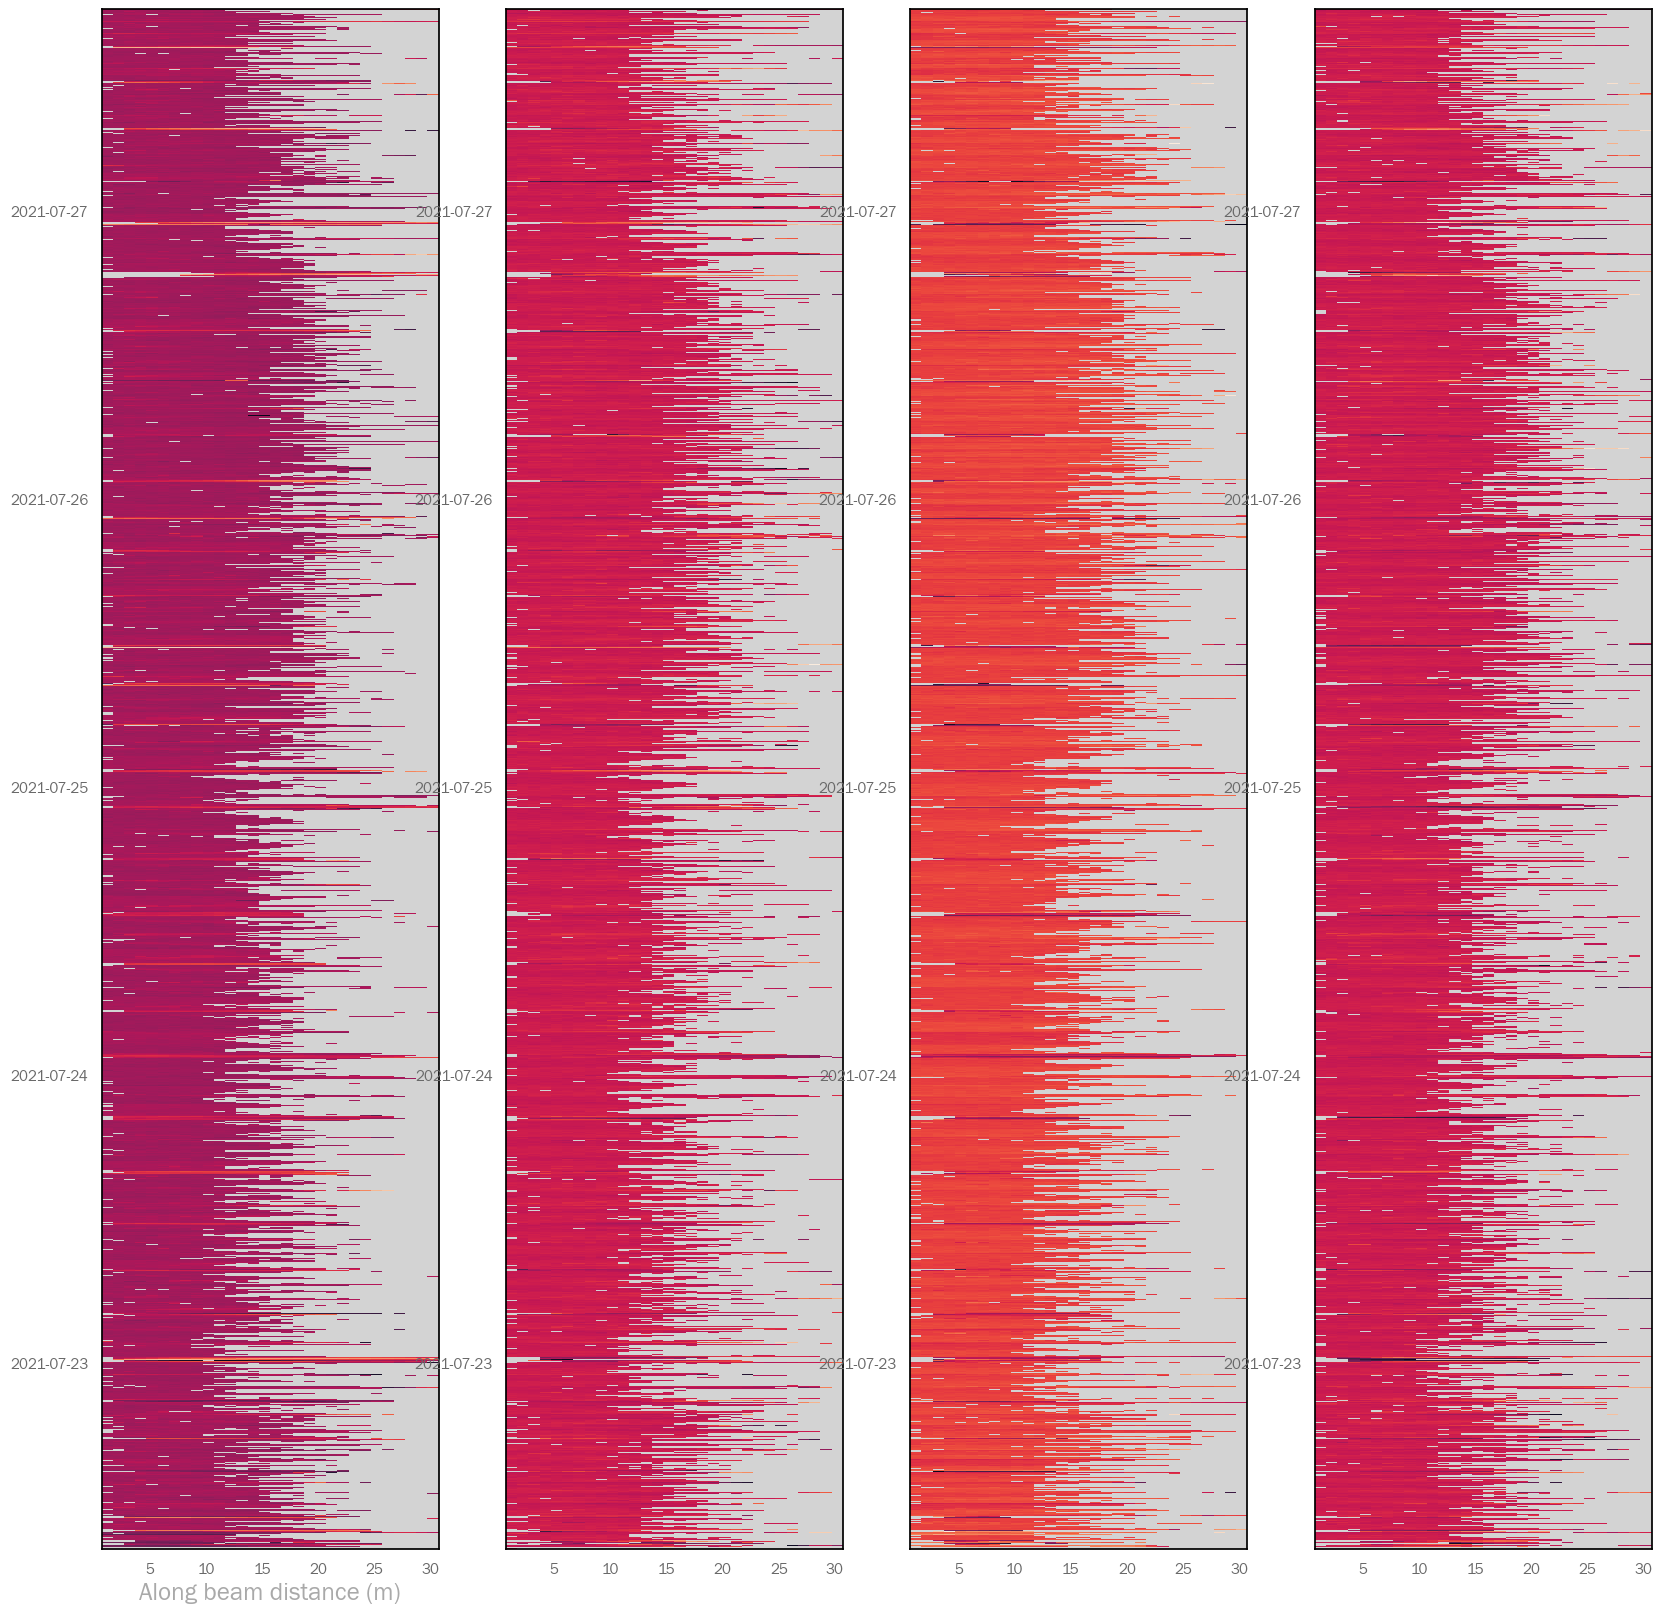

In [28]:
ADCP = process_adcp.remove_outliers(ADCP, options)

Should we interpolate over bad data? Reconstruct missing bins in profiles?

# How many good data per bin?

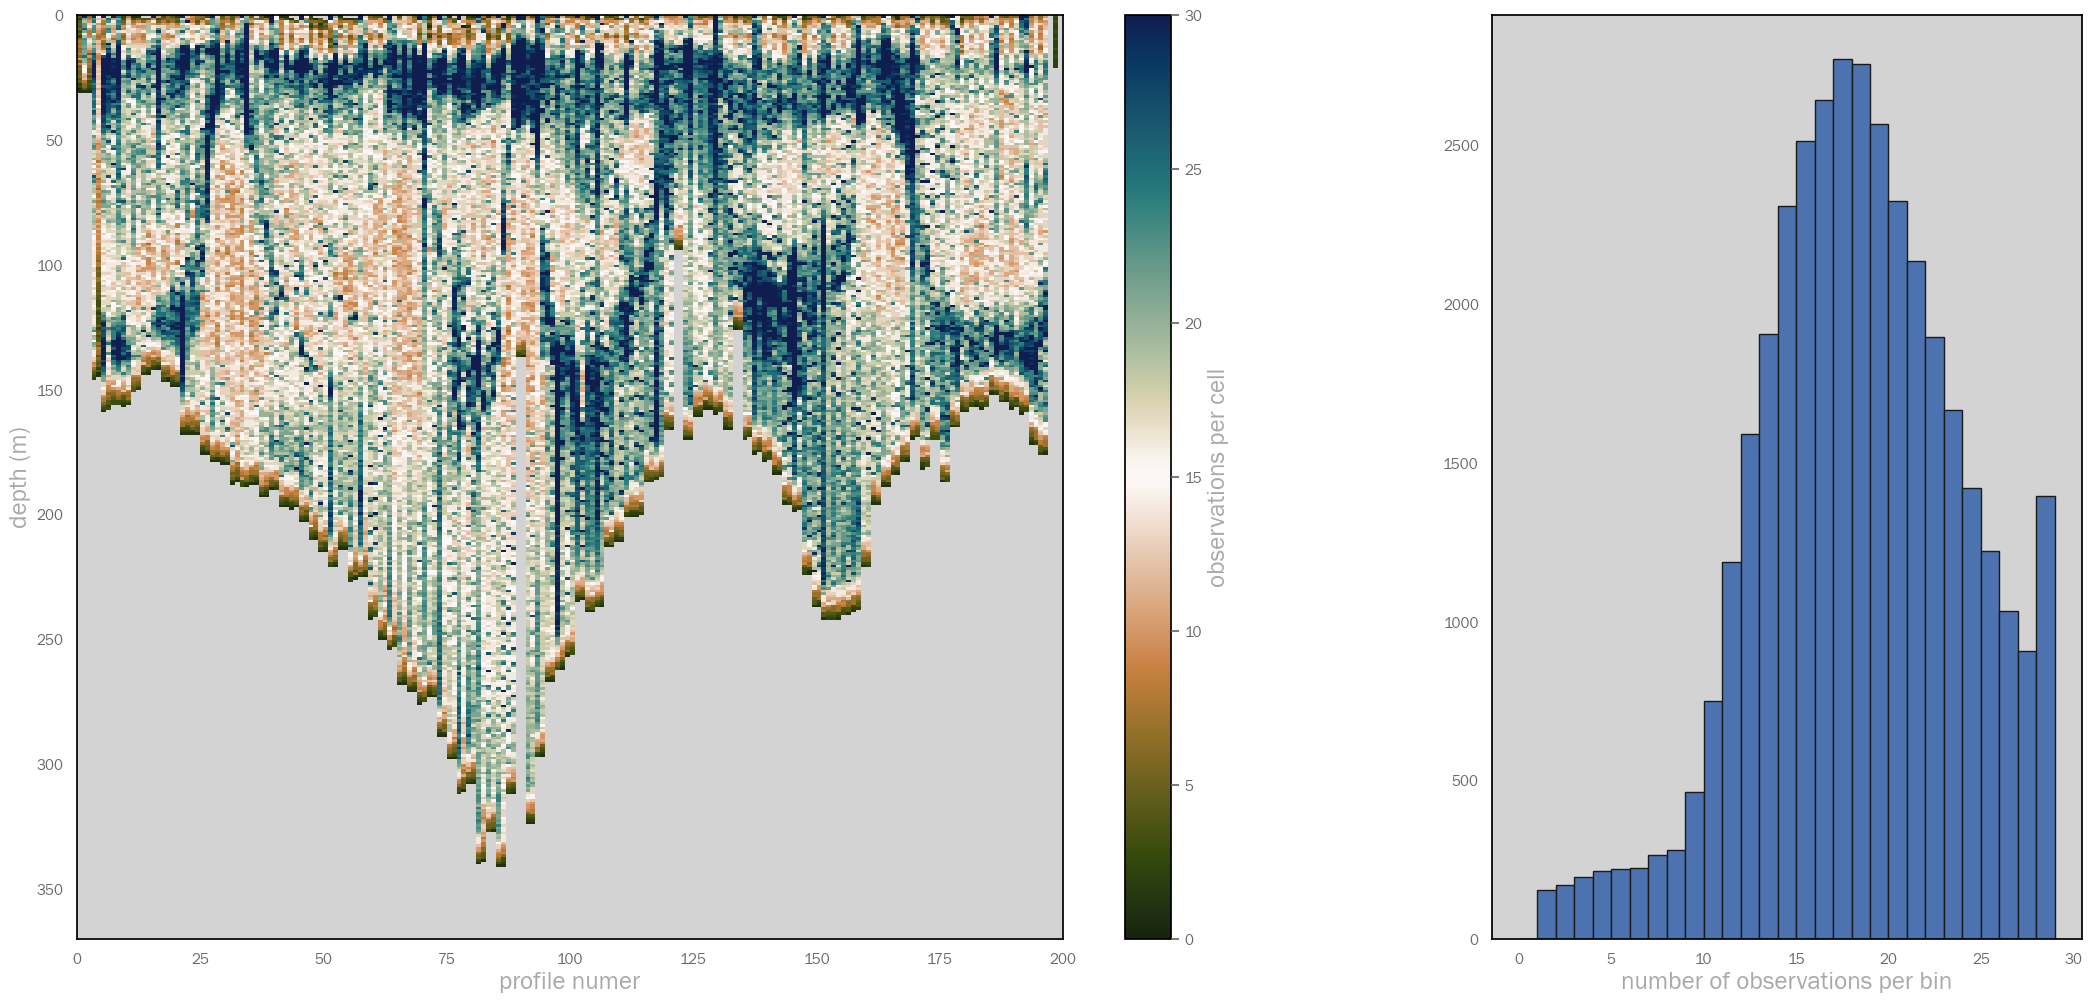

In [29]:
process_adcp.plot_data_density(ADCP, options)

### Correct shear bias

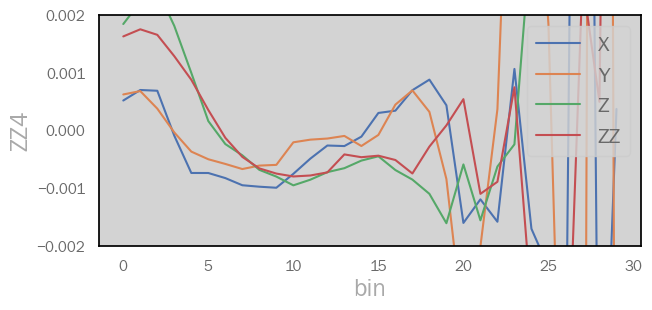

In [30]:
ADCP = process_adcp.correct_shear(ADCP, options)

### Pitching motion correction (TODO - or not TODO)

In [31]:
if options['ADCP_discardFirstBins']: print(ADCP.dims); ADCP = ADCP.isel(bin = ADCP['bin'] >= options['ADCP_discardFirstBins']); print(ADCP.dims); plog('Discarded first '+str(options['ADCP_discardFirstBins'])+' bins from ADCP data')

## 3.4. Correct ADCP acoustic backscatter data (TODO)

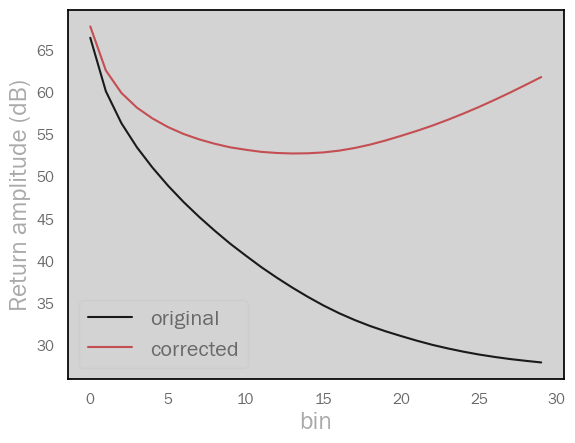

In [32]:
ADCP = process_adcp.correct_backscatter(ADCP, data, options)

## 3.5. Remap 3-beam configuration onto isobars

Using the following depth offsets:
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5]
 
Running gridding on all 4 beams:
2023-07-24 11:38:02 : Calculating beam 1
2023-07-24 11:38:03 : Calculating beam 2
2023-07-24 11:38:05 : Calculating beam 3
2023-07-24 11:38:06 : Calculating beam 4


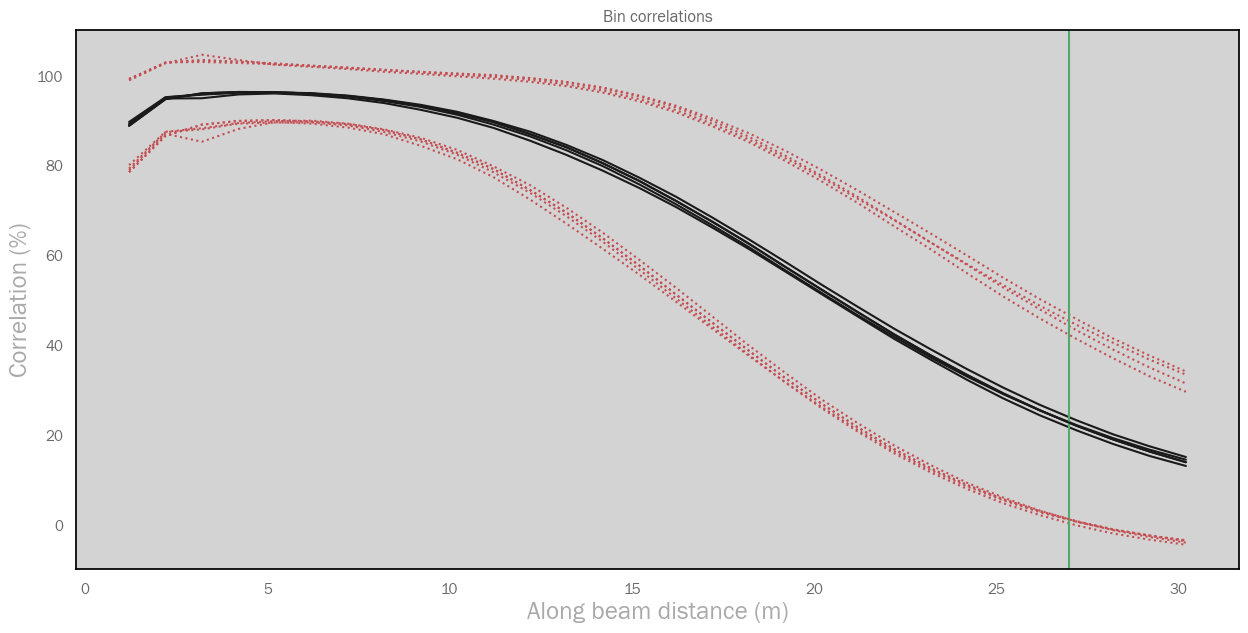

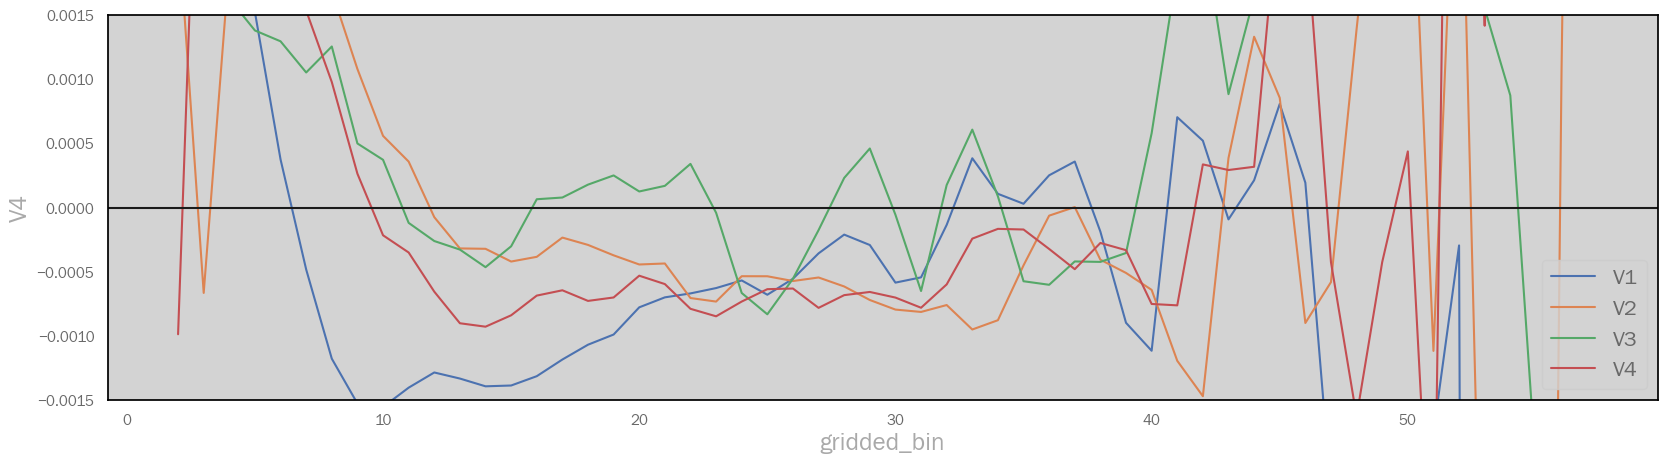

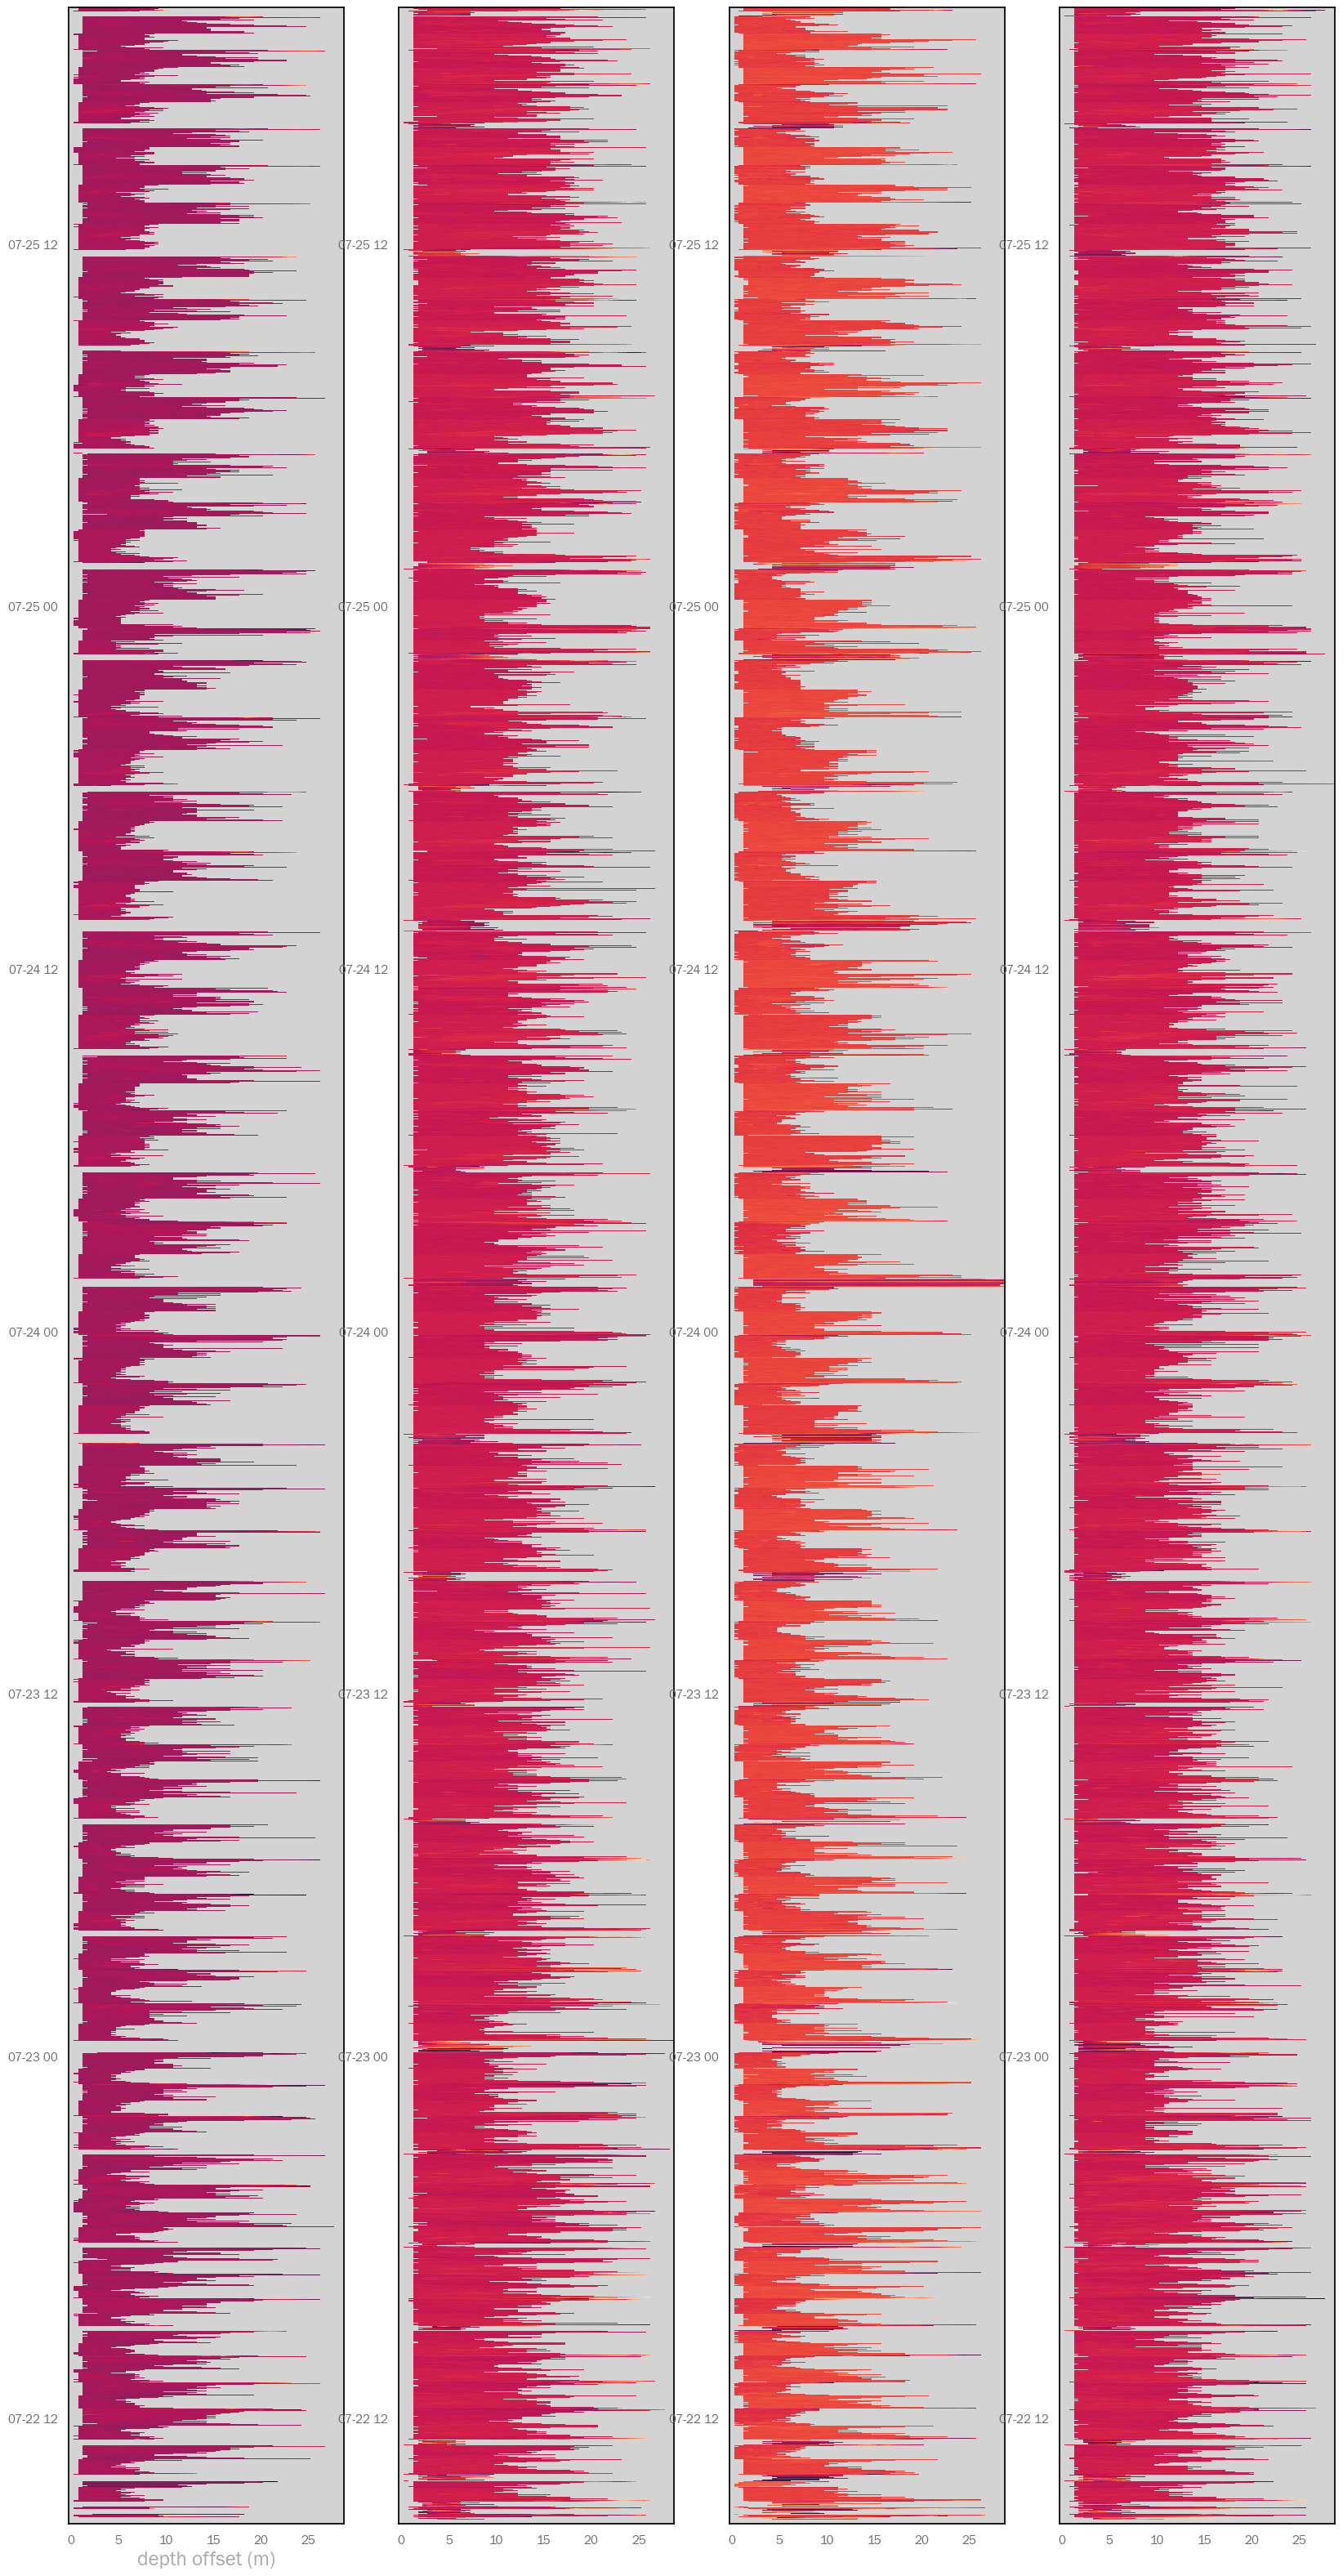

In [33]:
ADCP = process_adcp.regridADCPdata(ADCP, options)

## 3.6. Transform beams to XYZ and ENU velocities

Assuming ADCP is top mounted
2023-07-24 11:38:15 : Calculating X,Y,Z from isobaric 3-beam measurements.


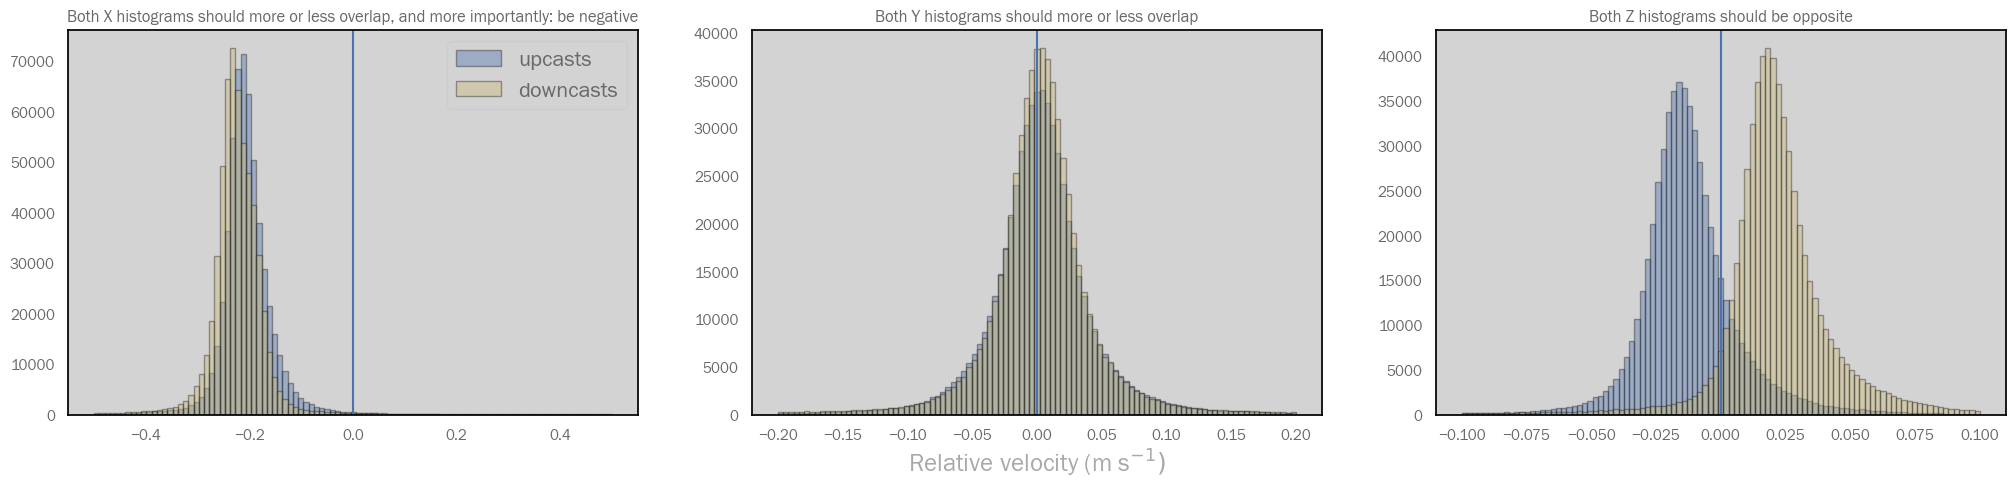

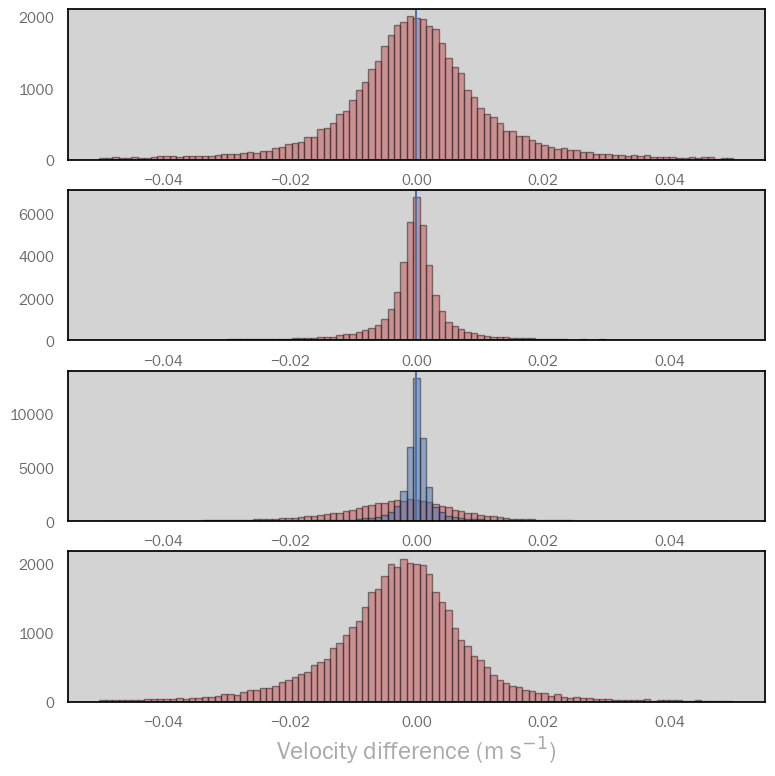

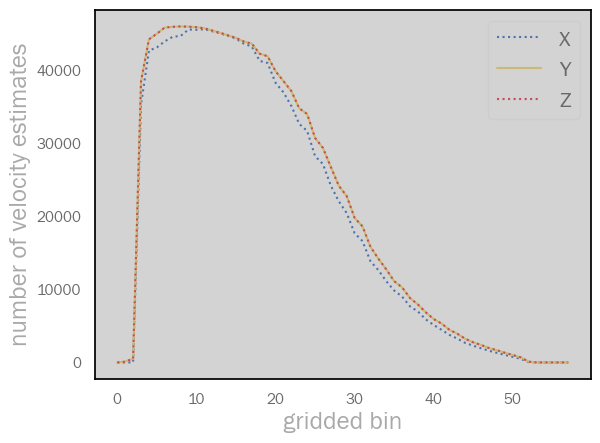

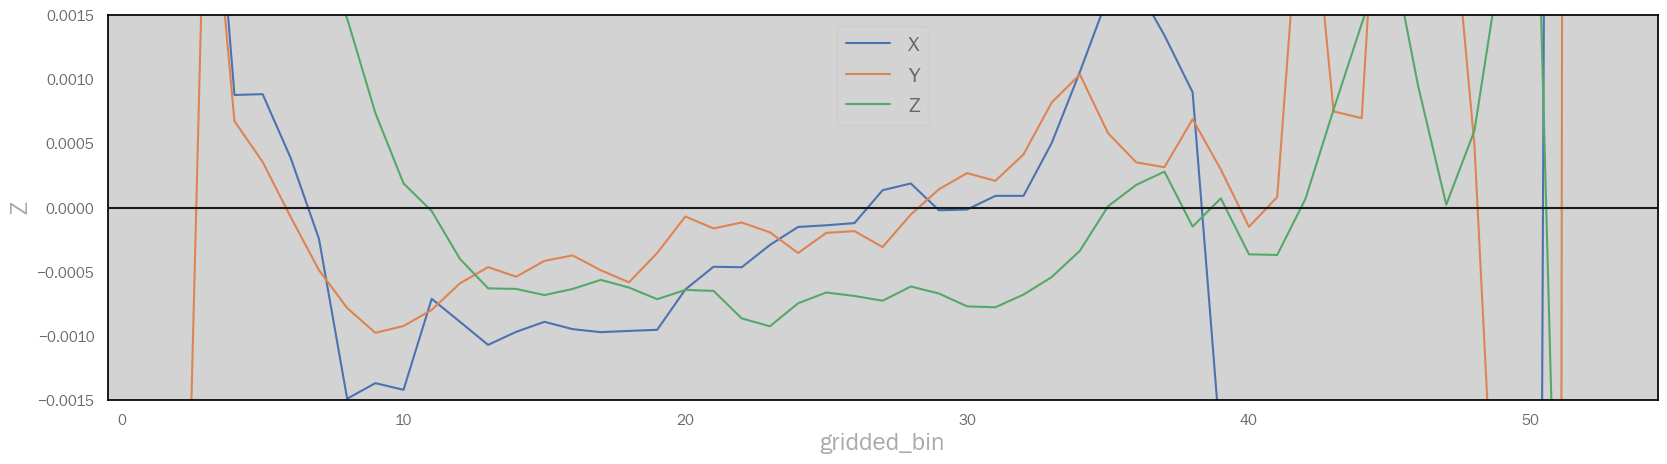

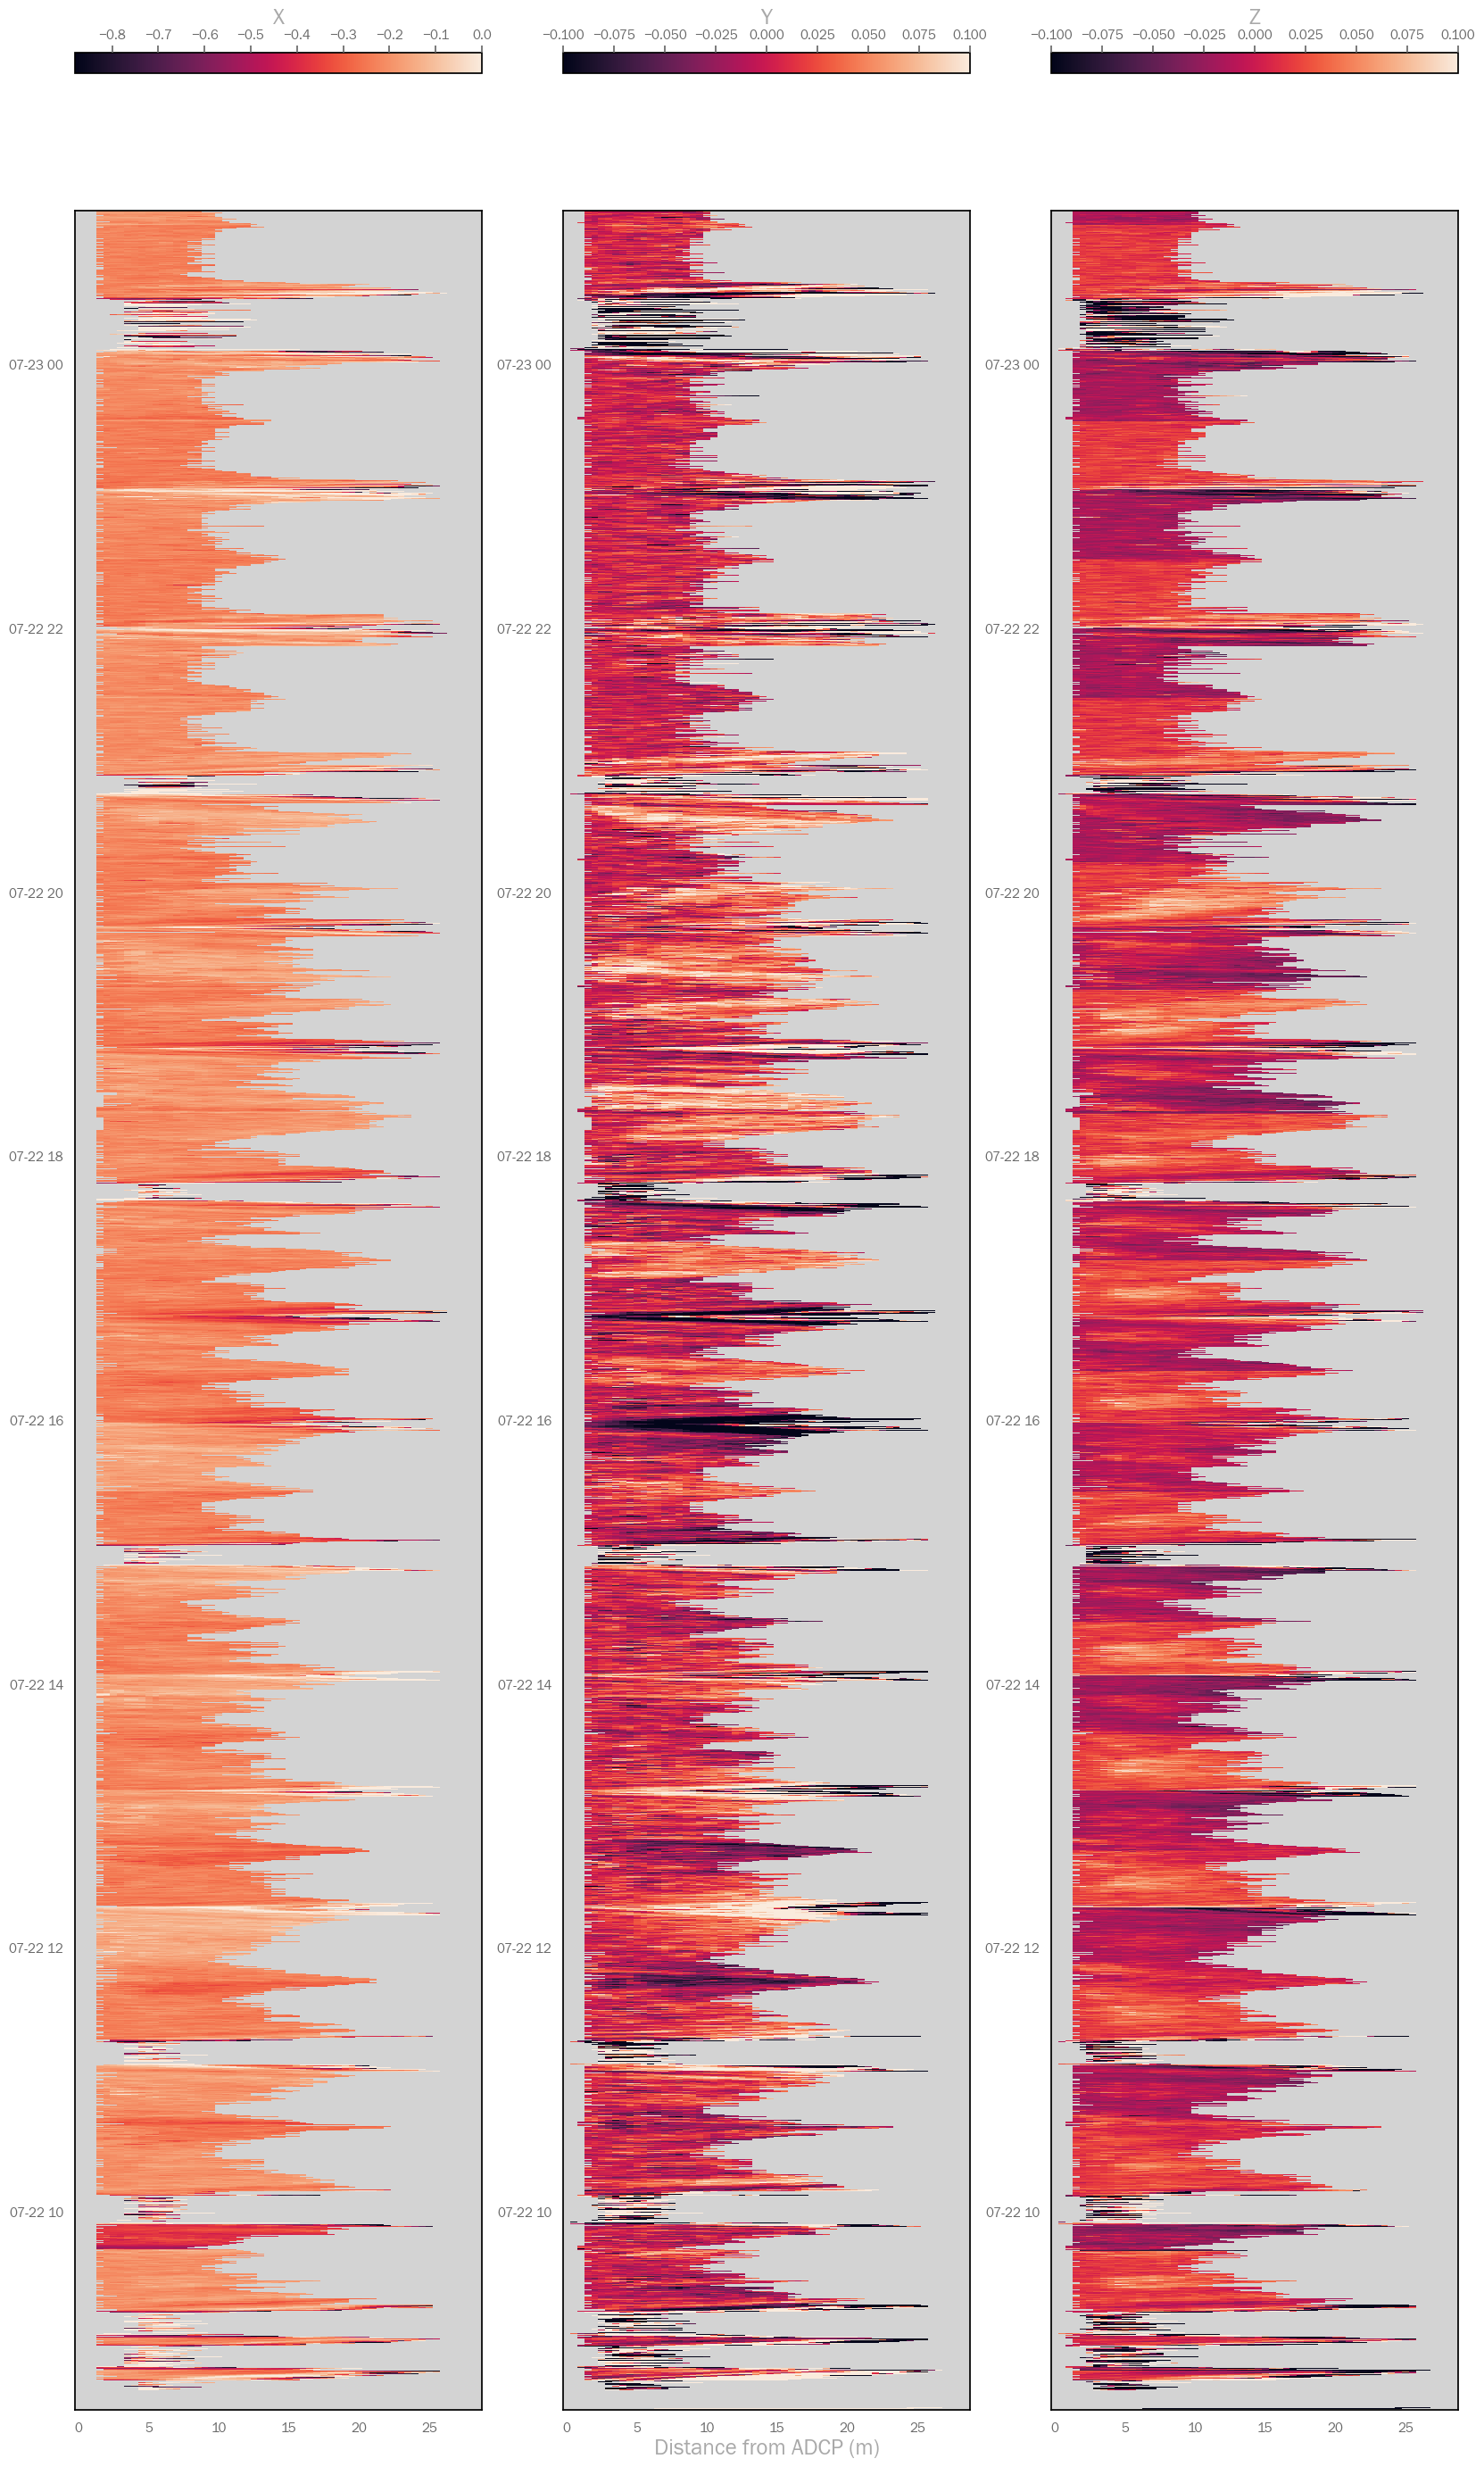

In [34]:
ADCP = process_adcp.calcXYZfrom3beam(ADCP, options)

2023-07-24 11:38:19 : Converted from XYZ to ENU


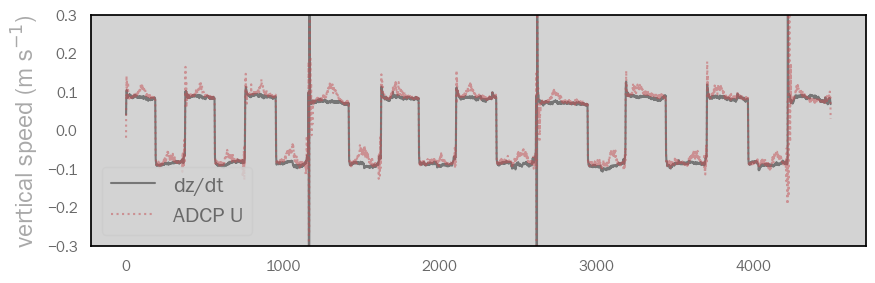

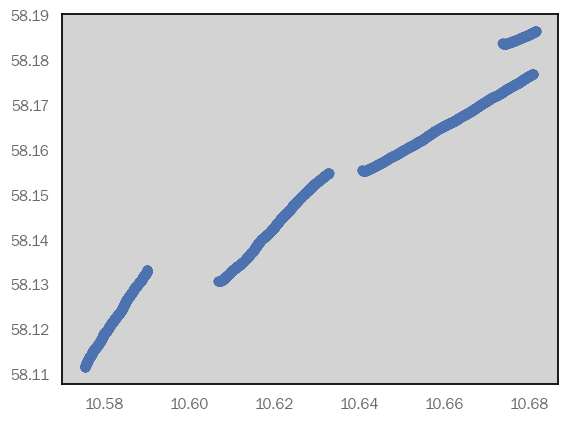

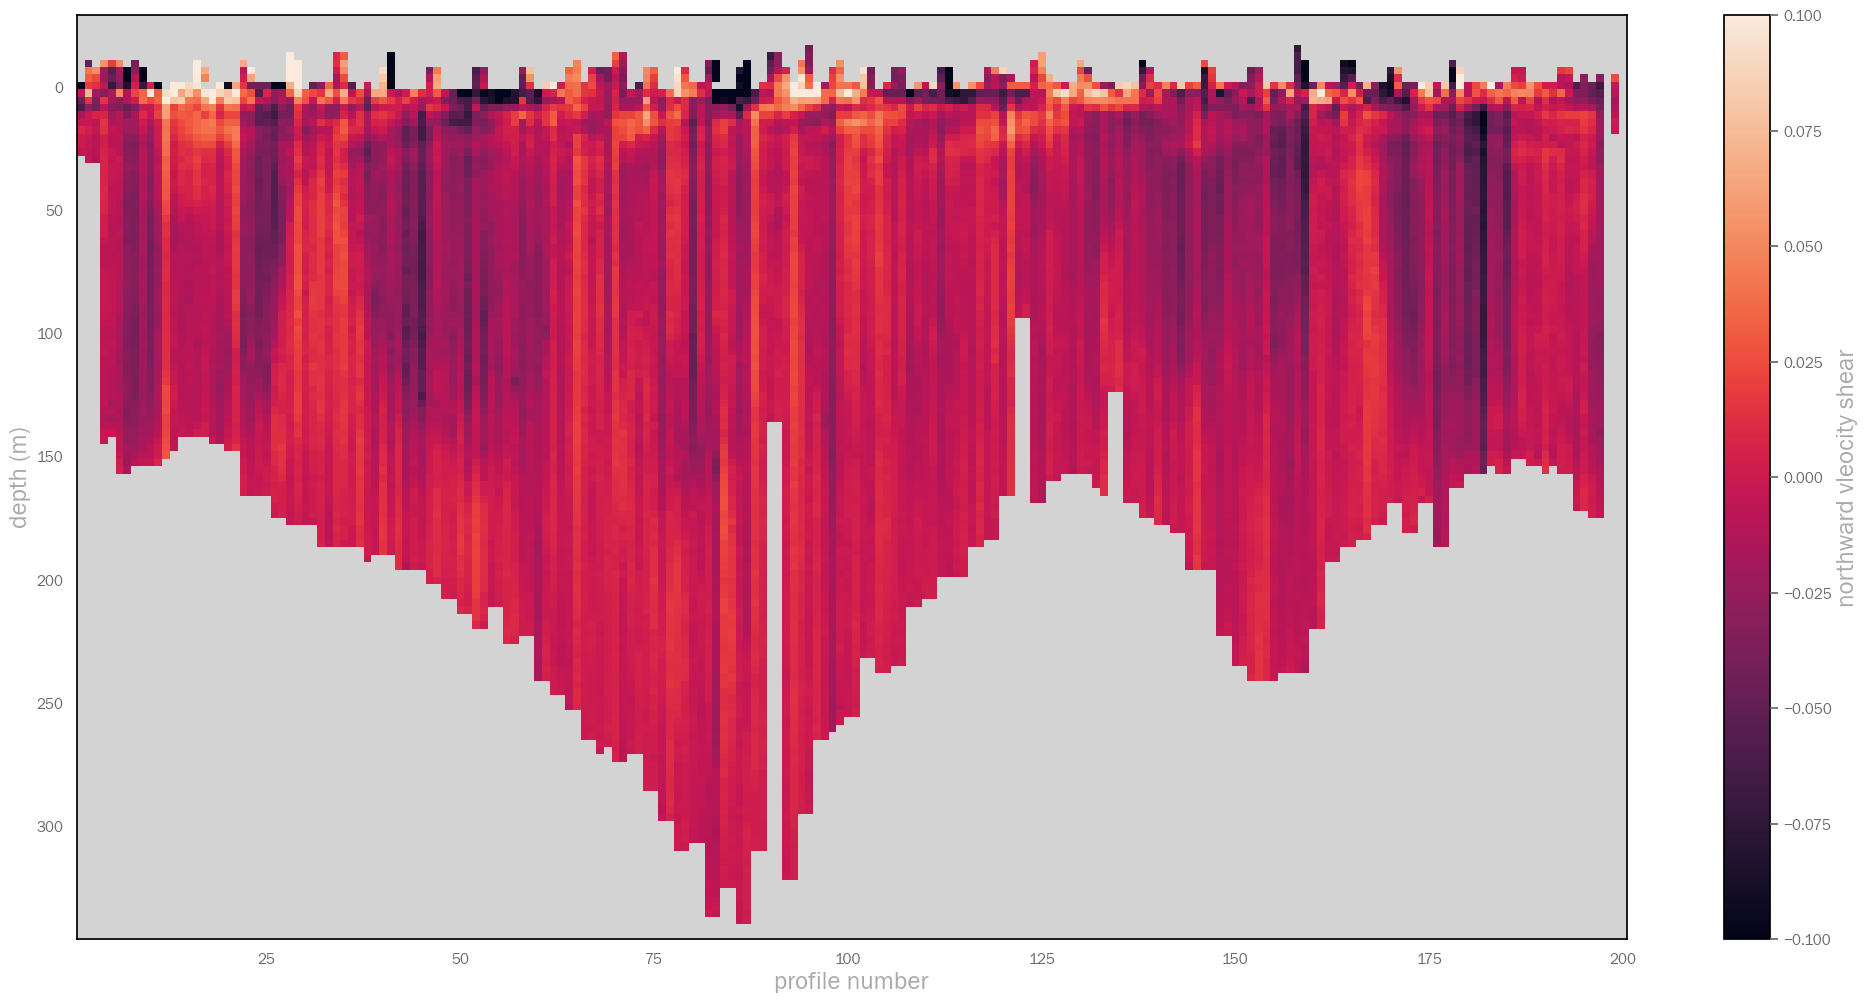

In [35]:
ADCP = process_adcp.calcENUfromXYZ(ADCP, data, options)

## Check if errors in the above are related to motor movements?

22043 21207


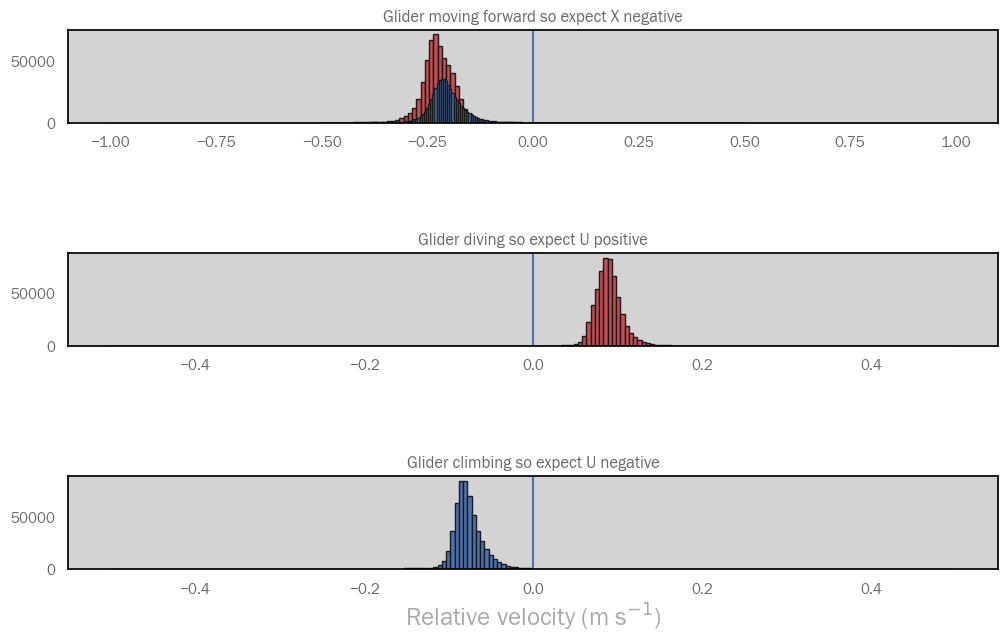

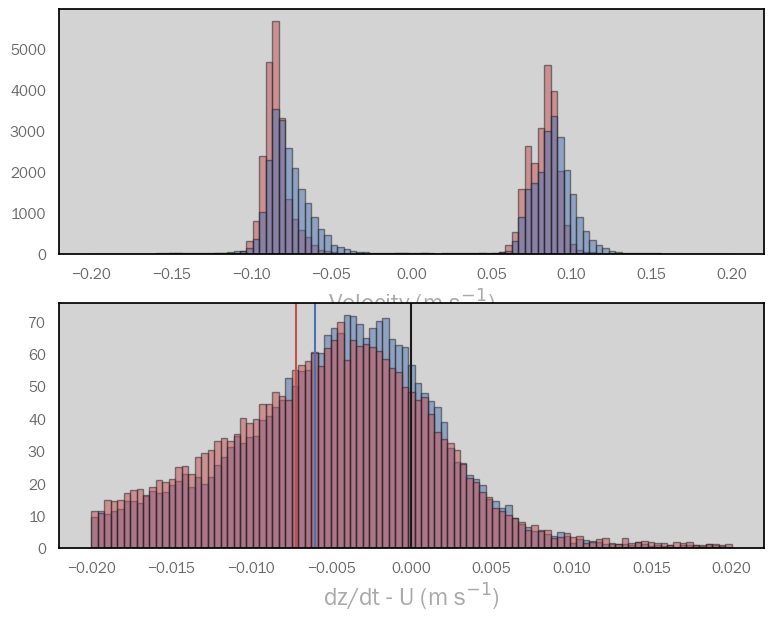

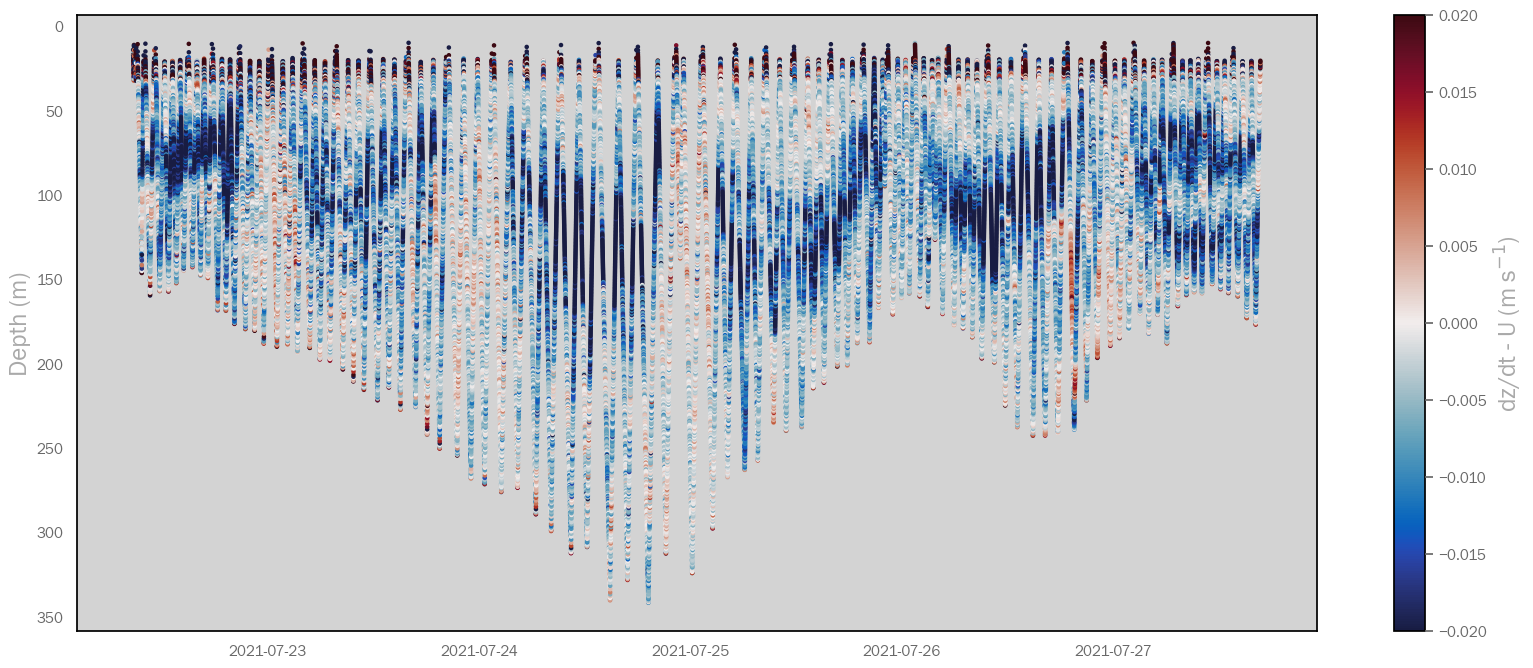

In [36]:
process_adcp.verify_calcENUfromXYZ(ADCP, options)

### Mismatch above sign of misalignment of ADCP / incorrect pitch/roll ?

## 3.7. Grid shear

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 27.60it/s]


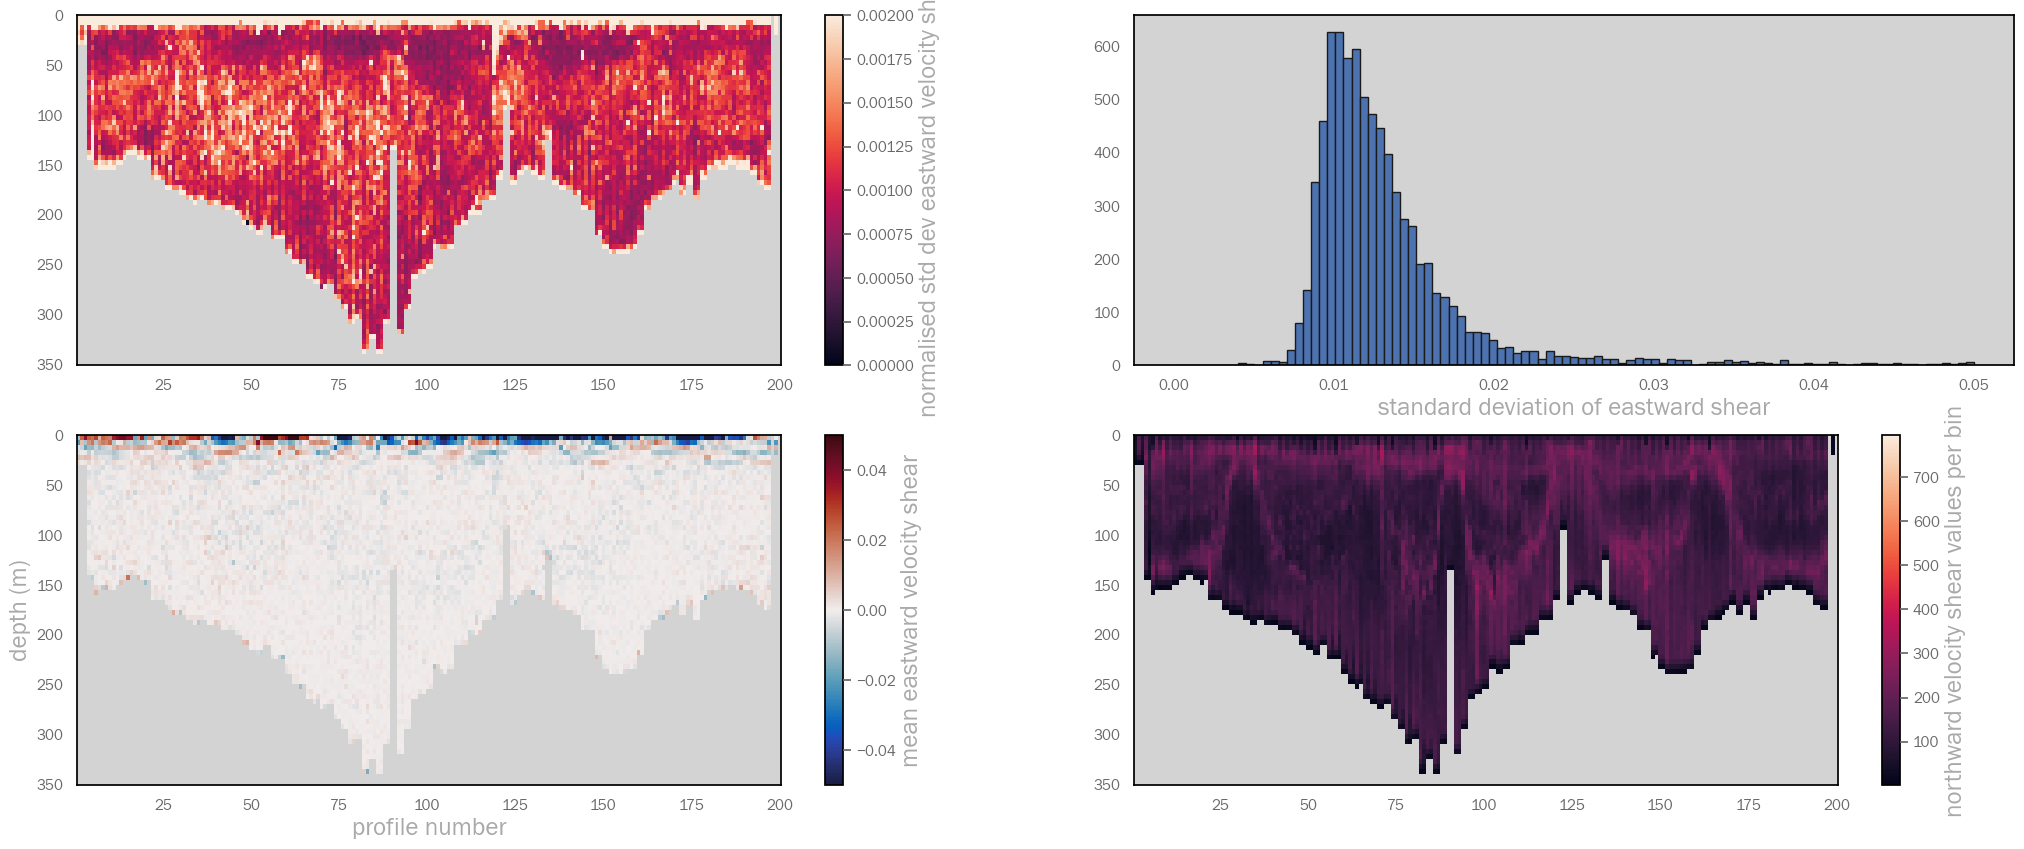

In [37]:
xaxis, yaxis, taxis, days = process_adcp.grid_shear_data(ADCP, data, options)
out = process_adcp.grid_data(ADCP, data, {}, xaxis, yaxis)
ds = process_adcp.make_dataset(out)

# 3.8 Write out data

**ds** is an xarray dataset of data gridded by depth bin and profile number, ready for processing

In [38]:
ds

<xarray.Dataset>
Dimensions:         (depth_bin: 344, profile_num: 198)
Coordinates:
  * profile_num     (profile_num) int64 0 1 2 3 4 5 ... 192 193 194 195 196 197
  * depth_bin       (depth_bin) int64 0 1 2 3 4 5 6 ... 338 339 340 341 342 343
Data variables: (12/15)
    Sh_E            (depth_bin, profile_num) float64 nan -0.1007 ... nan nan
    Sh_N            (depth_bin, profile_num) float64 nan -0.1009 ... nan nan
    Sh_U            (depth_bin, profile_num) float64 nan -0.01229 ... nan nan
    Heading         (depth_bin, profile_num) float64 nan nan nan ... nan nan nan
    Pitch           (depth_bin, profile_num) float64 nan nan nan ... nan nan nan
    Roll            (depth_bin, profile_num) float64 nan nan nan ... nan nan nan
    ...              ...
    Pressure        (depth_bin, profile_num) float64 nan nan nan ... nan nan nan
    temperature     (depth_bin, profile_num) float64 nan nan nan ... nan nan nan
    salinity        (depth_bin, profile_num) float64 nan nan nan ... nan nan nan
    pressure        (depth_bin, profile_num) float64 nan nan nan ... nan nan nan
    date_float      (depth_bin, profile_num) float64 nan nan nan ... nan nan nan
    soundspeed      (depth_bin, profile_num) float64 nan nan nan ... nan nan nan